In [ ]:
# Imports
import time
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# Define hyperparameters
batch_size = 120
random_seed = 41
num_epochs = 100

# Set random seed for reproducibility
torch.manual_seed(random_seed)

In [ ]:
# Download data from torchvision
train_set = datasets.MNIST(root='data',
                         train=True,
                         download=True,
                         transform=transforms.ToTensor())

test_set = datasets.MNIST(root='data',
                          train=False,
                          transform=transforms.ToTensor())

In [ ]:
# Create Dataloader for iterative loading
train_loader=DataLoader(batch_size=batch_size,dataset=train_set,shuffle=True)
test_loader=DataLoader(batch_size=batch_size,dataset=test_set,shuffle=False)

In [ ]:
# Check Dataloader
for features, label in train_loader:
  print(f'Image dimension : {features.shape}')
  print(f'Label dimension: {label.shape}')
  break

Image dimension : torch.Size([120, 1, 28, 28])
Label dimension: torch.Size([120])


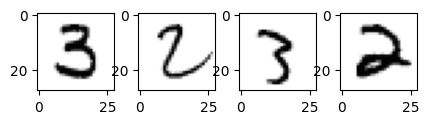

In [ ]:
# Check first 4 images
fig, ax = plt.subplots(1, 4, figsize = (5, 1))
for i in range(4):
    ax[i].imshow(features[i].reshape(28, 28), cmap='Greys')

plt.show()

In [ ]:
# Define MLP
class MLP(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size):
        super().__init__()

        # Define the first (hidden) layer with input and hidden layer sizes
        self.hidden_layer = torch.nn.Linear(input_size, hidden_layer_size)
        self.hidden_layer.weight.detach().normal_(0.0, 0.1)
        self.hidden_layer.bias.detach().zero_()

        # Define the output layer with hidden layer and output sizes
        self.output_layer = torch.nn.Linear(hidden_layer_size, output_size)
        self.output_layer.weight.detach().normal_(0.0, 0.1)
        self.output_layer.bias.detach().zero_()

    def forward(self, x):
        # Apply sigmoid to the first (hidden) layer
        hidden_output = self.hidden_layer(x)
        activated_output = torch.sigmoid(hidden_output)

        # Get outputs (logits) output layer
        logits = self.output_layer(activated_output)
        return logits

In [ ]:
# Initialise model
model = MLP(input_size= 28*28, output_size=10, hidden_layer_size = 90)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
# Define training
epoch_cost=[]
mini_batch_cost=[]

start_time = time.time()
for epoch in range(num_epochs):
  mini_batch_costs , num_batches = 0., 0.

  for batch_idx, (features , label) in enumerate(train_loader):
      features = features.view(-1, 28*28)

      # Forward and Backward
      logits = model(features)

      cost = F.cross_entropy(logits, label)
      optimizer.zero_grad()

      cost.backward()

      # Update parameters
      optimizer.step()

      mini_batch_cost.append(cost.item())

      mini_batch_costs += cost.item()
      num_batches += 1

      if batch_idx % 50 == 0:
        print(f'Epoch : {epoch + 1:03d}/{num_epochs:03d} | Batch {batch_idx:03d}/{len(train_loader)} | Cost : {cost.item():.3f}')


  total_cost= mini_batch_costs / num_batches
  epoch_cost.append(total_cost)
  print(f'Epoch : {epoch + 1:03d}/{num_epochs:03d} |  Train Cost : {total_cost:.3f}')
  print(f'Time elapsed: {(((time.time() - start_time)/60)):.2f} min')

print(f"Total Training Time: {((time.time() - start_time)/60):.2f} min")


Epoch : 001/100 | Batch 000/500 | Cost : 2.398
Epoch : 001/100 | Batch 050/500 | Cost : 1.926
Epoch : 001/100 | Batch 100/500 | Cost : 1.622
Epoch : 001/100 | Batch 150/500 | Cost : 1.233
Epoch : 001/100 | Batch 200/500 | Cost : 0.991
Epoch : 001/100 | Batch 250/500 | Cost : 0.850
Epoch : 001/100 | Batch 300/500 | Cost : 0.814
Epoch : 001/100 | Batch 350/500 | Cost : 0.645
Epoch : 001/100 | Batch 400/500 | Cost : 0.634
Epoch : 001/100 | Batch 450/500 | Cost : 0.454
Epoch : 001/100 |  Train Cost : 1.078
Time elapsed: 0.30 min
Epoch : 002/100 | Batch 000/500 | Cost : 0.600
Epoch : 002/100 | Batch 050/500 | Cost : 0.471
Epoch : 002/100 | Batch 100/500 | Cost : 0.590
Epoch : 002/100 | Batch 150/500 | Cost : 0.542
Epoch : 002/100 | Batch 200/500 | Cost : 0.405
Epoch : 002/100 | Batch 250/500 | Cost : 0.530
Epoch : 002/100 | Batch 300/500 | Cost : 0.415
Epoch : 002/100 | Batch 350/500 | Cost : 0.420
Epoch : 002/100 | Batch 400/500 | Cost : 0.377
Epoch : 002/100 | Batch 450/500 | Cost : 0.464

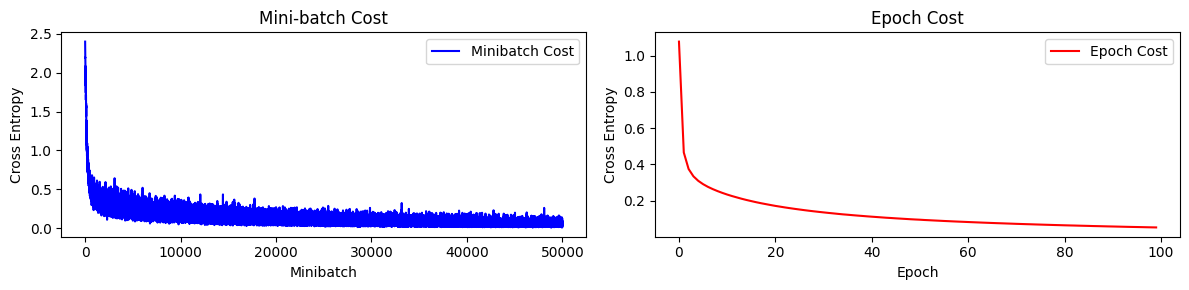

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Plot mini-batch costs
axs[0].plot(mini_batch_cost, color='blue', label='Minibatch Cost')
axs[0].set_ylabel('Cross Entropy')
axs[0].set_xlabel('Minibatch')
axs[0].legend()
axs[0].set_title('Mini-batch Cost')

# Plot epoch costs
axs[1].plot(epoch_cost, color='red', label='Epoch Cost')
axs[1].set_ylabel('Cross Entropy')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[1].set_title('Epoch Cost')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Compute Accuracy
def model_accuracy(model, data_loader):
  correct_pred, num_examples = 0, 0
  with torch.no_grad():  # Not tracking gradients
        for features, targets in data_loader:
            features = features.view(-1, 28*28)
            logits = model.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += torch.sum(predicted_labels == targets)
        return (correct_pred / num_examples) * 100

print(f'Training Accuracy: {(model_accuracy(model, train_loader)):.2f}%')
print(f'Test Accuracy: {(model_accuracy(model, test_loader)):.2f}%')

Training Accuracy: 98.70%
Test Accuracy: 97.52%
